# Importing libraries

In [12]:
import argparse
import os
import numpy as np
import math
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler 
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

# Required Parameters

In [13]:
epochs = 50
batch_size = 32
learning_rate = 0.001
img_shape = (3, 28, 28)
interval = 100
b1 = 0.5
b2 = 0.999

In [14]:
os.makedirs("images_q3_autogan", exist_ok=True)

# Generator

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #self.encoder_output = None
        self.encoder = nn.Sequential(
            nn.Linear(28*28*3, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12),
            nn.ReLU(True), 
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True), 
            nn.Linear(64, 28*28*3), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        #self.encoder_output = x.detach().numpy()
        x = self.decoder(x)
        #x = x.view(x.size(0), *img_shape)
        return x

# Discriminator

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)

        return validity

In [17]:
adversarial_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()

In [18]:
generator = Generator()
discriminator = Discriminator()

In [19]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2))

# Loading the input data

In [20]:
Tensor = torch.FloatTensor

In [21]:
root_dir = 'faces94'
files = glob(f"{root_dir}/**/**/*.jpg")

In [22]:
files[:10]

['faces94/malestaff/doraj/doraj.17.jpg',
 'faces94/malestaff/doraj/doraj.12.jpg',
 'faces94/malestaff/doraj/doraj.16.jpg',
 'faces94/malestaff/doraj/doraj.11.jpg',
 'faces94/malestaff/doraj/doraj.18.jpg',
 'faces94/malestaff/doraj/doraj.2.jpg',
 'faces94/malestaff/doraj/doraj.10.jpg',
 'faces94/malestaff/doraj/doraj.5.jpg',
 'faces94/malestaff/doraj/doraj.9.jpg',
 'faces94/malestaff/doraj/doraj.1.jpg']

3059


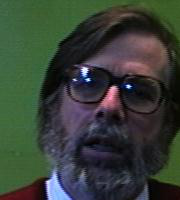

In [23]:
print(len(files))
Image.open(files[1])

In [13]:
c2i = {
    "female": 0,
    "male":1,
    "malestaff": 2 
}

In [14]:
transform_loader = transforms.Compose([
    transforms.RandomResizedCrop((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

all_imgs = torch.stack([transform_loader(Image.open(x)) for x in files])
all_label = torch.tensor([c2i[x.split('/')[-3]] for x in files])

train_idx, test_idx = train_test_split(range(len(all_imgs)), test_size=0.2, random_state=102)

train_img = all_imgs[train_idx]
train_label = all_label[train_idx]

test_img = all_imgs[test_idx]
test_label = all_label[test_idx]

train_data = TensorDataset(train_img, train_label)
test_data = TensorDataset(test_img, test_label)

train_samp = RandomSampler(train_data)
test_samp = SequentialSampler(test_data)

train_loader = DataLoader(train_data, sampler=train_samp, batch_size=32)
test_loader = DataLoader(test_data, sampler=test_samp, batch_size=32)
print("done")

done


# Training

In [15]:
g_loss_vals = []
d_loss_vals = []
for epoch in range(epochs):
    for i, (imgs,_) in enumerate(train_loader):
             
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(Tensor))
        optimizer_G.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 3*28*28))))
        gen_imgs = generator(z)
        
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) + mse_loss(gen_imgs, real_imgs.view(real_imgs.shape[0], -1))
        g_loss.backward()
        
        optimizer_G.step()
        
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, epochs, i, len(train_loader), d_loss.item(), g_loss.item())
        )
        
        batches_done = epoch * len(train_loader) + i
        if batches_done % interval == 0:
            save_image(gen_imgs.view(-1, 3, 28, 28), "images_q3_autogan/%d.png" % batches_done, nrow=5, normalize=True)
    g_loss_vals.append(g_loss.item())
    d_loss_vals.append(d_loss.item())

[Epoch 0/50] [Batch 0/77] [D loss: 0.702095] [G loss: 1.014822]
[Epoch 0/50] [Batch 1/77] [D loss: 0.487137] [G loss: 1.075703]
[Epoch 0/50] [Batch 2/77] [D loss: 0.401180] [G loss: 1.075929]
[Epoch 0/50] [Batch 3/77] [D loss: 0.316805] [G loss: 1.197293]
[Epoch 0/50] [Batch 4/77] [D loss: 0.299871] [G loss: 1.334489]
[Epoch 0/50] [Batch 5/77] [D loss: 0.214103] [G loss: 1.507653]
[Epoch 0/50] [Batch 6/77] [D loss: 0.168947] [G loss: 1.750232]
[Epoch 0/50] [Batch 7/77] [D loss: 0.110044] [G loss: 1.977291]
[Epoch 0/50] [Batch 8/77] [D loss: 0.100644] [G loss: 2.229486]
[Epoch 0/50] [Batch 9/77] [D loss: 0.088534] [G loss: 2.403971]
[Epoch 0/50] [Batch 10/77] [D loss: 0.060255] [G loss: 2.513468]
[Epoch 0/50] [Batch 11/77] [D loss: 0.059443] [G loss: 2.548983]
[Epoch 0/50] [Batch 12/77] [D loss: 0.065995] [G loss: 2.477697]
[Epoch 0/50] [Batch 13/77] [D loss: 0.088572] [G loss: 2.249613]
[Epoch 0/50] [Batch 14/77] [D loss: 0.119913] [G loss: 1.931132]
[Epoch 0/50] [Batch 15/77] [D loss:

[Epoch 1/50] [Batch 50/77] [D loss: 0.085907] [G loss: 2.393872]
[Epoch 1/50] [Batch 51/77] [D loss: 0.144787] [G loss: 2.793735]
[Epoch 1/50] [Batch 52/77] [D loss: 0.321360] [G loss: 1.076238]
[Epoch 1/50] [Batch 53/77] [D loss: 0.054075] [G loss: 6.438873]
[Epoch 1/50] [Batch 54/77] [D loss: 0.024515] [G loss: 5.704060]
[Epoch 1/50] [Batch 55/77] [D loss: 0.218864] [G loss: 2.988316]
[Epoch 1/50] [Batch 56/77] [D loss: 0.222821] [G loss: 1.771196]
[Epoch 1/50] [Batch 57/77] [D loss: 0.638957] [G loss: 3.336927]
[Epoch 1/50] [Batch 58/77] [D loss: 1.723173] [G loss: 0.351734]
[Epoch 1/50] [Batch 59/77] [D loss: 0.469285] [G loss: 0.810165]
[Epoch 1/50] [Batch 60/77] [D loss: 0.072227] [G loss: 2.734449]
[Epoch 1/50] [Batch 61/77] [D loss: 0.021026] [G loss: 4.087246]
[Epoch 1/50] [Batch 62/77] [D loss: 0.174382] [G loss: 4.206310]
[Epoch 1/50] [Batch 63/77] [D loss: 0.029631] [G loss: 3.232103]
[Epoch 1/50] [Batch 64/77] [D loss: 0.052851] [G loss: 2.651344]
[Epoch 1/50] [Batch 65/77

[Epoch 3/50] [Batch 29/77] [D loss: 0.043255] [G loss: 3.009618]
[Epoch 3/50] [Batch 30/77] [D loss: 0.316337] [G loss: 3.231749]
[Epoch 3/50] [Batch 31/77] [D loss: 1.582636] [G loss: 0.306324]
[Epoch 3/50] [Batch 32/77] [D loss: 0.868776] [G loss: 0.455722]
[Epoch 3/50] [Batch 33/77] [D loss: 0.311342] [G loss: 1.012780]
[Epoch 3/50] [Batch 34/77] [D loss: 0.142085] [G loss: 1.761775]
[Epoch 3/50] [Batch 35/77] [D loss: 0.167845] [G loss: 2.972667]
[Epoch 3/50] [Batch 36/77] [D loss: 0.077495] [G loss: 2.496744]
[Epoch 3/50] [Batch 37/77] [D loss: 0.060385] [G loss: 2.501451]
[Epoch 3/50] [Batch 38/77] [D loss: 0.050237] [G loss: 2.859819]
[Epoch 3/50] [Batch 39/77] [D loss: 0.050079] [G loss: 3.208654]
[Epoch 3/50] [Batch 40/77] [D loss: 0.027928] [G loss: 3.305064]
[Epoch 3/50] [Batch 41/77] [D loss: 0.026428] [G loss: 3.443496]
[Epoch 3/50] [Batch 42/77] [D loss: 0.020078] [G loss: 3.588666]
[Epoch 3/50] [Batch 43/77] [D loss: 0.053879] [G loss: 3.760824]
[Epoch 3/50] [Batch 44/77

[Epoch 5/50] [Batch 9/77] [D loss: 0.284752] [G loss: 1.368903]
[Epoch 5/50] [Batch 10/77] [D loss: 0.146043] [G loss: 2.431401]
[Epoch 5/50] [Batch 11/77] [D loss: 0.169456] [G loss: 2.690679]
[Epoch 5/50] [Batch 12/77] [D loss: 0.114327] [G loss: 2.019797]
[Epoch 5/50] [Batch 13/77] [D loss: 0.108925] [G loss: 2.232195]
[Epoch 5/50] [Batch 14/77] [D loss: 0.093285] [G loss: 2.644432]
[Epoch 5/50] [Batch 15/77] [D loss: 0.103952] [G loss: 2.575607]
[Epoch 5/50] [Batch 16/77] [D loss: 0.097367] [G loss: 2.576733]
[Epoch 5/50] [Batch 17/77] [D loss: 0.082725] [G loss: 2.335533]
[Epoch 5/50] [Batch 18/77] [D loss: 0.076299] [G loss: 2.894130]
[Epoch 5/50] [Batch 19/77] [D loss: 0.130025] [G loss: 2.840913]
[Epoch 5/50] [Batch 20/77] [D loss: 0.216718] [G loss: 1.338705]
[Epoch 5/50] [Batch 21/77] [D loss: 0.279815] [G loss: 4.056579]
[Epoch 5/50] [Batch 22/77] [D loss: 0.339129] [G loss: 0.998524]
[Epoch 5/50] [Batch 23/77] [D loss: 0.092823] [G loss: 2.255931]
[Epoch 5/50] [Batch 24/77]

[Epoch 6/50] [Batch 67/77] [D loss: 0.352917] [G loss: 1.126113]
[Epoch 6/50] [Batch 68/77] [D loss: 0.258093] [G loss: 1.478618]
[Epoch 6/50] [Batch 69/77] [D loss: 0.226020] [G loss: 3.381698]
[Epoch 6/50] [Batch 70/77] [D loss: 0.170642] [G loss: 1.886457]
[Epoch 6/50] [Batch 71/77] [D loss: 0.169991] [G loss: 1.776094]
[Epoch 6/50] [Batch 72/77] [D loss: 0.146047] [G loss: 3.247002]
[Epoch 6/50] [Batch 73/77] [D loss: 0.173771] [G loss: 1.764026]
[Epoch 6/50] [Batch 74/77] [D loss: 0.097971] [G loss: 2.302759]
[Epoch 6/50] [Batch 75/77] [D loss: 0.215046] [G loss: 3.218959]
[Epoch 6/50] [Batch 76/77] [D loss: 0.736449] [G loss: 0.691679]
[Epoch 7/50] [Batch 0/77] [D loss: 0.460954] [G loss: 4.072951]
[Epoch 7/50] [Batch 1/77] [D loss: 0.285870] [G loss: 1.407785]
[Epoch 7/50] [Batch 2/77] [D loss: 0.184630] [G loss: 1.538102]
[Epoch 7/50] [Batch 3/77] [D loss: 0.220468] [G loss: 2.873550]
[Epoch 7/50] [Batch 4/77] [D loss: 0.133347] [G loss: 2.348352]
[Epoch 7/50] [Batch 5/77] [D l

[Epoch 8/50] [Batch 46/77] [D loss: 0.279705] [G loss: 2.621491]
[Epoch 8/50] [Batch 47/77] [D loss: 0.253058] [G loss: 1.263618]
[Epoch 8/50] [Batch 48/77] [D loss: 0.526381] [G loss: 4.720524]
[Epoch 8/50] [Batch 49/77] [D loss: 0.347305] [G loss: 1.243549]
[Epoch 8/50] [Batch 50/77] [D loss: 0.071617] [G loss: 2.942628]
[Epoch 8/50] [Batch 51/77] [D loss: 0.229115] [G loss: 3.739890]
[Epoch 8/50] [Batch 52/77] [D loss: 0.208792] [G loss: 1.450635]
[Epoch 8/50] [Batch 53/77] [D loss: 0.171961] [G loss: 3.137777]
[Epoch 8/50] [Batch 54/77] [D loss: 0.135337] [G loss: 3.008549]
[Epoch 8/50] [Batch 55/77] [D loss: 0.148739] [G loss: 2.025501]
[Epoch 8/50] [Batch 56/77] [D loss: 0.108465] [G loss: 2.573910]
[Epoch 8/50] [Batch 57/77] [D loss: 0.117362] [G loss: 3.709050]
[Epoch 8/50] [Batch 58/77] [D loss: 0.257382] [G loss: 1.590066]
[Epoch 8/50] [Batch 59/77] [D loss: 0.280549] [G loss: 5.686671]
[Epoch 8/50] [Batch 60/77] [D loss: 0.145994] [G loss: 2.966054]
[Epoch 8/50] [Batch 61/77

[Epoch 10/50] [Batch 19/77] [D loss: 0.105958] [G loss: 3.075033]
[Epoch 10/50] [Batch 20/77] [D loss: 0.034645] [G loss: 3.997972]
[Epoch 10/50] [Batch 21/77] [D loss: 0.101623] [G loss: 3.781929]
[Epoch 10/50] [Batch 22/77] [D loss: 0.313395] [G loss: 1.492870]
[Epoch 10/50] [Batch 23/77] [D loss: 0.215107] [G loss: 6.271070]
[Epoch 10/50] [Batch 24/77] [D loss: 0.125566] [G loss: 2.633011]
[Epoch 10/50] [Batch 25/77] [D loss: 0.105824] [G loss: 2.290412]
[Epoch 10/50] [Batch 26/77] [D loss: 0.100079] [G loss: 4.490661]
[Epoch 10/50] [Batch 27/77] [D loss: 0.071610] [G loss: 3.036940]
[Epoch 10/50] [Batch 28/77] [D loss: 0.039507] [G loss: 3.224608]
[Epoch 10/50] [Batch 29/77] [D loss: 0.036807] [G loss: 3.262924]
[Epoch 10/50] [Batch 30/77] [D loss: 0.222023] [G loss: 3.953283]
[Epoch 10/50] [Batch 31/77] [D loss: 2.224583] [G loss: 0.309904]
[Epoch 10/50] [Batch 32/77] [D loss: 2.410664] [G loss: 10.265732]
[Epoch 10/50] [Batch 33/77] [D loss: 0.290644] [G loss: 4.384695]
[Epoch 10

[Epoch 11/50] [Batch 76/77] [D loss: 0.212487] [G loss: 2.163774]
[Epoch 12/50] [Batch 0/77] [D loss: 0.181019] [G loss: 2.667164]
[Epoch 12/50] [Batch 1/77] [D loss: 0.403292] [G loss: 2.712897]
[Epoch 12/50] [Batch 2/77] [D loss: 0.361045] [G loss: 2.662444]
[Epoch 12/50] [Batch 3/77] [D loss: 0.199530] [G loss: 3.263166]
[Epoch 12/50] [Batch 4/77] [D loss: 0.364462] [G loss: 1.702130]
[Epoch 12/50] [Batch 5/77] [D loss: 0.298845] [G loss: 1.899324]
[Epoch 12/50] [Batch 6/77] [D loss: 0.252049] [G loss: 2.466755]
[Epoch 12/50] [Batch 7/77] [D loss: 0.085812] [G loss: 3.498693]
[Epoch 12/50] [Batch 8/77] [D loss: 0.320653] [G loss: 3.379864]
[Epoch 12/50] [Batch 9/77] [D loss: 0.585083] [G loss: 1.131693]
[Epoch 12/50] [Batch 10/77] [D loss: 1.156498] [G loss: 7.873967]
[Epoch 12/50] [Batch 11/77] [D loss: 0.510534] [G loss: 3.084893]
[Epoch 12/50] [Batch 12/77] [D loss: 0.091491] [G loss: 3.296698]
[Epoch 12/50] [Batch 13/77] [D loss: 0.107809] [G loss: 4.528368]
[Epoch 12/50] [Batch

[Epoch 13/50] [Batch 51/77] [D loss: 0.174576] [G loss: 1.713954]
[Epoch 13/50] [Batch 52/77] [D loss: 0.173019] [G loss: 3.233812]
[Epoch 13/50] [Batch 53/77] [D loss: 0.130866] [G loss: 3.006193]
[Epoch 13/50] [Batch 54/77] [D loss: 0.216178] [G loss: 2.225843]
[Epoch 13/50] [Batch 55/77] [D loss: 0.249986] [G loss: 3.449533]
[Epoch 13/50] [Batch 56/77] [D loss: 0.196294] [G loss: 2.807988]
[Epoch 13/50] [Batch 57/77] [D loss: 0.302796] [G loss: 1.522991]
[Epoch 13/50] [Batch 58/77] [D loss: 0.246248] [G loss: 2.670017]
[Epoch 13/50] [Batch 59/77] [D loss: 0.182978] [G loss: 2.410538]
[Epoch 13/50] [Batch 60/77] [D loss: 0.259166] [G loss: 1.555308]
[Epoch 13/50] [Batch 61/77] [D loss: 0.336406] [G loss: 3.790872]
[Epoch 13/50] [Batch 62/77] [D loss: 0.155418] [G loss: 2.170290]
[Epoch 13/50] [Batch 63/77] [D loss: 0.150179] [G loss: 2.106224]
[Epoch 13/50] [Batch 64/77] [D loss: 0.093721] [G loss: 3.118159]
[Epoch 13/50] [Batch 65/77] [D loss: 0.139635] [G loss: 2.960424]
[Epoch 13/

[Epoch 15/50] [Batch 24/77] [D loss: 0.426667] [G loss: 1.517796]
[Epoch 15/50] [Batch 25/77] [D loss: 0.282005] [G loss: 2.753358]
[Epoch 15/50] [Batch 26/77] [D loss: 0.323816] [G loss: 2.075955]
[Epoch 15/50] [Batch 27/77] [D loss: 0.329349] [G loss: 1.486457]
[Epoch 15/50] [Batch 28/77] [D loss: 0.336149] [G loss: 3.280048]
[Epoch 15/50] [Batch 29/77] [D loss: 0.248501] [G loss: 1.865193]
[Epoch 15/50] [Batch 30/77] [D loss: 0.220064] [G loss: 1.730843]
[Epoch 15/50] [Batch 31/77] [D loss: 0.243583] [G loss: 3.481933]
[Epoch 15/50] [Batch 32/77] [D loss: 0.170872] [G loss: 2.406817]
[Epoch 15/50] [Batch 33/77] [D loss: 0.171061] [G loss: 2.207748]
[Epoch 15/50] [Batch 34/77] [D loss: 0.338891] [G loss: 3.763530]
[Epoch 15/50] [Batch 35/77] [D loss: 0.294894] [G loss: 1.403550]
[Epoch 15/50] [Batch 36/77] [D loss: 0.217645] [G loss: 3.017137]
[Epoch 15/50] [Batch 37/77] [D loss: 0.292617] [G loss: 2.641073]
[Epoch 15/50] [Batch 38/77] [D loss: 0.381212] [G loss: 1.229704]
[Epoch 15/

[Epoch 16/50] [Batch 75/77] [D loss: 0.240205] [G loss: 2.945083]
[Epoch 16/50] [Batch 76/77] [D loss: 0.434111] [G loss: 1.097546]
[Epoch 17/50] [Batch 0/77] [D loss: 1.473187] [G loss: 8.735677]
[Epoch 17/50] [Batch 1/77] [D loss: 0.541215] [G loss: 1.154768]
[Epoch 17/50] [Batch 2/77] [D loss: 0.531564] [G loss: 2.311647]
[Epoch 17/50] [Batch 3/77] [D loss: 0.304998] [G loss: 3.621636]
[Epoch 17/50] [Batch 4/77] [D loss: 0.293407] [G loss: 2.108850]
[Epoch 17/50] [Batch 5/77] [D loss: 0.353884] [G loss: 2.249276]
[Epoch 17/50] [Batch 6/77] [D loss: 0.221429] [G loss: 3.275519]
[Epoch 17/50] [Batch 7/77] [D loss: 0.229109] [G loss: 1.956539]
[Epoch 17/50] [Batch 8/77] [D loss: 0.263201] [G loss: 2.754033]
[Epoch 17/50] [Batch 9/77] [D loss: 0.302572] [G loss: 2.415874]
[Epoch 17/50] [Batch 10/77] [D loss: 0.311365] [G loss: 2.070065]
[Epoch 17/50] [Batch 11/77] [D loss: 0.216215] [G loss: 3.007363]
[Epoch 17/50] [Batch 12/77] [D loss: 0.262834] [G loss: 2.634480]
[Epoch 17/50] [Batch

[Epoch 18/50] [Batch 49/77] [D loss: 0.383101] [G loss: 1.040878]
[Epoch 18/50] [Batch 50/77] [D loss: 0.489886] [G loss: 5.049073]
[Epoch 18/50] [Batch 51/77] [D loss: 0.286183] [G loss: 2.756519]
[Epoch 18/50] [Batch 52/77] [D loss: 0.379170] [G loss: 1.173535]
[Epoch 18/50] [Batch 53/77] [D loss: 0.193546] [G loss: 3.562547]
[Epoch 18/50] [Batch 54/77] [D loss: 0.373833] [G loss: 3.295881]
[Epoch 18/50] [Batch 55/77] [D loss: 0.268560] [G loss: 1.516935]
[Epoch 18/50] [Batch 56/77] [D loss: 0.201296] [G loss: 2.466489]
[Epoch 18/50] [Batch 57/77] [D loss: 0.149311] [G loss: 3.611531]
[Epoch 18/50] [Batch 58/77] [D loss: 0.116152] [G loss: 2.618313]
[Epoch 18/50] [Batch 59/77] [D loss: 0.091271] [G loss: 2.624559]
[Epoch 18/50] [Batch 60/77] [D loss: 0.194696] [G loss: 2.997078]
[Epoch 18/50] [Batch 61/77] [D loss: 0.260361] [G loss: 1.498156]
[Epoch 18/50] [Batch 62/77] [D loss: 0.844286] [G loss: 5.372530]
[Epoch 18/50] [Batch 63/77] [D loss: 0.252412] [G loss: 1.707759]
[Epoch 18/

[Epoch 20/50] [Batch 27/77] [D loss: 0.193729] [G loss: 2.358451]
[Epoch 20/50] [Batch 28/77] [D loss: 0.134681] [G loss: 2.617522]
[Epoch 20/50] [Batch 29/77] [D loss: 0.168802] [G loss: 2.888854]
[Epoch 20/50] [Batch 30/77] [D loss: 0.131960] [G loss: 2.401923]
[Epoch 20/50] [Batch 31/77] [D loss: 0.305685] [G loss: 2.640802]
[Epoch 20/50] [Batch 32/77] [D loss: 0.155115] [G loss: 3.363099]
[Epoch 20/50] [Batch 33/77] [D loss: 0.298922] [G loss: 1.874641]
[Epoch 20/50] [Batch 34/77] [D loss: 0.620907] [G loss: 4.703657]
[Epoch 20/50] [Batch 35/77] [D loss: 0.655821] [G loss: 0.703676]
[Epoch 20/50] [Batch 36/77] [D loss: 0.229053] [G loss: 3.862288]
[Epoch 20/50] [Batch 37/77] [D loss: 0.505396] [G loss: 3.990161]
[Epoch 20/50] [Batch 38/77] [D loss: 0.238564] [G loss: 1.767706]
[Epoch 20/50] [Batch 39/77] [D loss: 0.296805] [G loss: 1.410328]
[Epoch 20/50] [Batch 40/77] [D loss: 0.126294] [G loss: 2.603878]
[Epoch 20/50] [Batch 41/77] [D loss: 0.282440] [G loss: 3.155890]
[Epoch 20/

[Epoch 21/50] [Batch 75/77] [D loss: 0.334547] [G loss: 3.731414]
[Epoch 21/50] [Batch 76/77] [D loss: 0.233202] [G loss: 1.996842]
[Epoch 22/50] [Batch 0/77] [D loss: 0.268202] [G loss: 2.526923]
[Epoch 22/50] [Batch 1/77] [D loss: 0.417452] [G loss: 3.056343]
[Epoch 22/50] [Batch 2/77] [D loss: 0.511857] [G loss: 1.148939]
[Epoch 22/50] [Batch 3/77] [D loss: 0.506610] [G loss: 4.647051]
[Epoch 22/50] [Batch 4/77] [D loss: 0.191163] [G loss: 2.730944]
[Epoch 22/50] [Batch 5/77] [D loss: 0.223591] [G loss: 1.962485]
[Epoch 22/50] [Batch 6/77] [D loss: 0.155044] [G loss: 2.383590]
[Epoch 22/50] [Batch 7/77] [D loss: 0.180120] [G loss: 3.279908]
[Epoch 22/50] [Batch 8/77] [D loss: 0.131131] [G loss: 2.897060]
[Epoch 22/50] [Batch 9/77] [D loss: 0.152222] [G loss: 2.161797]
[Epoch 22/50] [Batch 10/77] [D loss: 0.538662] [G loss: 4.658657]
[Epoch 22/50] [Batch 11/77] [D loss: 0.907409] [G loss: 0.828589]
[Epoch 22/50] [Batch 12/77] [D loss: 0.381434] [G loss: 4.408002]
[Epoch 22/50] [Batch

[Epoch 23/50] [Batch 52/77] [D loss: 0.659281] [G loss: 5.357547]
[Epoch 23/50] [Batch 53/77] [D loss: 0.192904] [G loss: 2.900090]
[Epoch 23/50] [Batch 54/77] [D loss: 0.613436] [G loss: 1.354030]
[Epoch 23/50] [Batch 55/77] [D loss: 0.282396] [G loss: 4.052050]
[Epoch 23/50] [Batch 56/77] [D loss: 0.408276] [G loss: 4.634155]
[Epoch 23/50] [Batch 57/77] [D loss: 0.164391] [G loss: 2.135426]
[Epoch 23/50] [Batch 58/77] [D loss: 0.219303] [G loss: 2.397864]
[Epoch 23/50] [Batch 59/77] [D loss: 0.180387] [G loss: 2.876064]
[Epoch 23/50] [Batch 60/77] [D loss: 0.178897] [G loss: 2.215025]
[Epoch 23/50] [Batch 61/77] [D loss: 0.201486] [G loss: 3.501989]
[Epoch 23/50] [Batch 62/77] [D loss: 0.190430] [G loss: 2.029644]
[Epoch 23/50] [Batch 63/77] [D loss: 0.177860] [G loss: 2.734961]
[Epoch 23/50] [Batch 64/77] [D loss: 0.278373] [G loss: 2.823476]
[Epoch 23/50] [Batch 65/77] [D loss: 0.149863] [G loss: 2.082574]
[Epoch 23/50] [Batch 66/77] [D loss: 0.245674] [G loss: 4.102400]
[Epoch 23/

[Epoch 25/50] [Batch 23/77] [D loss: 0.144373] [G loss: 1.999439]
[Epoch 25/50] [Batch 24/77] [D loss: 0.143063] [G loss: 3.010146]
[Epoch 25/50] [Batch 25/77] [D loss: 0.135400] [G loss: 3.829501]
[Epoch 25/50] [Batch 26/77] [D loss: 0.203850] [G loss: 2.061944]
[Epoch 25/50] [Batch 27/77] [D loss: 0.208479] [G loss: 3.018587]
[Epoch 25/50] [Batch 28/77] [D loss: 0.231134] [G loss: 3.271934]
[Epoch 25/50] [Batch 29/77] [D loss: 0.298971] [G loss: 1.739643]
[Epoch 25/50] [Batch 30/77] [D loss: 0.379801] [G loss: 4.057610]
[Epoch 25/50] [Batch 31/77] [D loss: 0.383348] [G loss: 1.396471]
[Epoch 25/50] [Batch 32/77] [D loss: 0.427563] [G loss: 4.426105]
[Epoch 25/50] [Batch 33/77] [D loss: 0.302565] [G loss: 2.974166]
[Epoch 25/50] [Batch 34/77] [D loss: 0.669188] [G loss: 0.840765]
[Epoch 25/50] [Batch 35/77] [D loss: 0.370974] [G loss: 4.944504]
[Epoch 25/50] [Batch 36/77] [D loss: 0.220482] [G loss: 4.092625]
[Epoch 25/50] [Batch 37/77] [D loss: 0.222928] [G loss: 2.157265]
[Epoch 25/

[Epoch 26/50] [Batch 74/77] [D loss: 0.543678] [G loss: 5.844516]
[Epoch 26/50] [Batch 75/77] [D loss: 0.432691] [G loss: 1.158107]
[Epoch 26/50] [Batch 76/77] [D loss: 0.301372] [G loss: 2.717547]
[Epoch 27/50] [Batch 0/77] [D loss: 0.277254] [G loss: 2.097001]
[Epoch 27/50] [Batch 1/77] [D loss: 0.227444] [G loss: 2.361257]
[Epoch 27/50] [Batch 2/77] [D loss: 0.216395] [G loss: 2.803773]
[Epoch 27/50] [Batch 3/77] [D loss: 0.235926] [G loss: 2.117310]
[Epoch 27/50] [Batch 4/77] [D loss: 0.210529] [G loss: 2.427104]
[Epoch 27/50] [Batch 5/77] [D loss: 0.178128] [G loss: 2.440127]
[Epoch 27/50] [Batch 6/77] [D loss: 0.427106] [G loss: 3.564371]
[Epoch 27/50] [Batch 7/77] [D loss: 0.766481] [G loss: 0.944210]
[Epoch 27/50] [Batch 8/77] [D loss: 0.489445] [G loss: 5.679437]
[Epoch 27/50] [Batch 9/77] [D loss: 0.439369] [G loss: 4.646327]
[Epoch 27/50] [Batch 10/77] [D loss: 0.232684] [G loss: 1.779554]
[Epoch 27/50] [Batch 11/77] [D loss: 0.277637] [G loss: 1.568826]
[Epoch 27/50] [Batch

[Epoch 28/50] [Batch 49/77] [D loss: 0.203881] [G loss: 2.620260]
[Epoch 28/50] [Batch 50/77] [D loss: 0.314960] [G loss: 1.765984]
[Epoch 28/50] [Batch 51/77] [D loss: 0.187111] [G loss: 3.414259]
[Epoch 28/50] [Batch 52/77] [D loss: 0.380489] [G loss: 2.620158]
[Epoch 28/50] [Batch 53/77] [D loss: 0.372227] [G loss: 2.705099]
[Epoch 28/50] [Batch 54/77] [D loss: 0.287256] [G loss: 2.197729]
[Epoch 28/50] [Batch 55/77] [D loss: 0.304820] [G loss: 2.830739]
[Epoch 28/50] [Batch 56/77] [D loss: 0.524541] [G loss: 1.888700]
[Epoch 28/50] [Batch 57/77] [D loss: 0.279705] [G loss: 2.628947]
[Epoch 28/50] [Batch 58/77] [D loss: 0.236094] [G loss: 3.535694]
[Epoch 28/50] [Batch 59/77] [D loss: 0.233242] [G loss: 2.276945]
[Epoch 28/50] [Batch 60/77] [D loss: 0.231954] [G loss: 2.110199]
[Epoch 28/50] [Batch 61/77] [D loss: 0.155192] [G loss: 2.898185]
[Epoch 28/50] [Batch 62/77] [D loss: 0.142904] [G loss: 3.176058]
[Epoch 28/50] [Batch 63/77] [D loss: 0.120150] [G loss: 2.904667]
[Epoch 28/

[Epoch 30/50] [Batch 24/77] [D loss: 0.314770] [G loss: 2.290080]
[Epoch 30/50] [Batch 25/77] [D loss: 0.497788] [G loss: 1.171947]
[Epoch 30/50] [Batch 26/77] [D loss: 0.263628] [G loss: 2.661144]
[Epoch 30/50] [Batch 27/77] [D loss: 0.191474] [G loss: 3.134373]
[Epoch 30/50] [Batch 28/77] [D loss: 0.312693] [G loss: 3.116314]
[Epoch 30/50] [Batch 29/77] [D loss: 0.320884] [G loss: 2.634029]
[Epoch 30/50] [Batch 30/77] [D loss: 0.281010] [G loss: 2.388554]
[Epoch 30/50] [Batch 31/77] [D loss: 0.324893] [G loss: 1.766730]
[Epoch 30/50] [Batch 32/77] [D loss: 0.157276] [G loss: 2.903705]
[Epoch 30/50] [Batch 33/77] [D loss: 0.365166] [G loss: 3.443312]
[Epoch 30/50] [Batch 34/77] [D loss: 0.309219] [G loss: 1.798334]
[Epoch 30/50] [Batch 35/77] [D loss: 0.310332] [G loss: 2.660918]
[Epoch 30/50] [Batch 36/77] [D loss: 0.269455] [G loss: 2.288967]
[Epoch 30/50] [Batch 37/77] [D loss: 0.252824] [G loss: 2.353078]
[Epoch 30/50] [Batch 38/77] [D loss: 0.232298] [G loss: 2.140970]
[Epoch 30/

[Epoch 32/50] [Batch 3/77] [D loss: 0.424013] [G loss: 3.608895]
[Epoch 32/50] [Batch 4/77] [D loss: 0.417483] [G loss: 2.221874]
[Epoch 32/50] [Batch 5/77] [D loss: 0.300599] [G loss: 1.608240]
[Epoch 32/50] [Batch 6/77] [D loss: 0.221127] [G loss: 2.456367]
[Epoch 32/50] [Batch 7/77] [D loss: 0.211159] [G loss: 2.490360]
[Epoch 32/50] [Batch 8/77] [D loss: 0.168801] [G loss: 2.452102]
[Epoch 32/50] [Batch 9/77] [D loss: 0.190140] [G loss: 2.209088]
[Epoch 32/50] [Batch 10/77] [D loss: 0.126986] [G loss: 2.718305]
[Epoch 32/50] [Batch 11/77] [D loss: 0.185837] [G loss: 3.036358]
[Epoch 32/50] [Batch 12/77] [D loss: 0.161044] [G loss: 2.318536]
[Epoch 32/50] [Batch 13/77] [D loss: 0.393772] [G loss: 2.006292]
[Epoch 32/50] [Batch 14/77] [D loss: 0.342301] [G loss: 2.852953]
[Epoch 32/50] [Batch 15/77] [D loss: 0.195756] [G loss: 2.086723]
[Epoch 32/50] [Batch 16/77] [D loss: 0.258304] [G loss: 2.470972]
[Epoch 32/50] [Batch 17/77] [D loss: 0.348612] [G loss: 2.063691]
[Epoch 32/50] [Ba

[Epoch 33/50] [Batch 56/77] [D loss: 0.162169] [G loss: 2.578157]
[Epoch 33/50] [Batch 57/77] [D loss: 0.120520] [G loss: 2.567623]
[Epoch 33/50] [Batch 58/77] [D loss: 0.149718] [G loss: 2.927335]
[Epoch 33/50] [Batch 59/77] [D loss: 0.345879] [G loss: 2.209672]
[Epoch 33/50] [Batch 60/77] [D loss: 0.257351] [G loss: 2.083013]
[Epoch 33/50] [Batch 61/77] [D loss: 0.301587] [G loss: 3.436796]
[Epoch 33/50] [Batch 62/77] [D loss: 0.211110] [G loss: 2.532922]
[Epoch 33/50] [Batch 63/77] [D loss: 0.252266] [G loss: 2.278431]
[Epoch 33/50] [Batch 64/77] [D loss: 0.212022] [G loss: 1.950548]
[Epoch 33/50] [Batch 65/77] [D loss: 0.265191] [G loss: 4.038978]
[Epoch 33/50] [Batch 66/77] [D loss: 0.403263] [G loss: 3.187517]
[Epoch 33/50] [Batch 67/77] [D loss: 0.596665] [G loss: 0.940257]
[Epoch 33/50] [Batch 68/77] [D loss: 0.538230] [G loss: 4.856680]
[Epoch 33/50] [Batch 69/77] [D loss: 0.122460] [G loss: 2.997680]
[Epoch 33/50] [Batch 70/77] [D loss: 0.218899] [G loss: 2.053648]
[Epoch 33/

[Epoch 35/50] [Batch 30/77] [D loss: 0.247928] [G loss: 2.165946]
[Epoch 35/50] [Batch 31/77] [D loss: 0.366176] [G loss: 4.278429]
[Epoch 35/50] [Batch 32/77] [D loss: 0.353038] [G loss: 1.671930]
[Epoch 35/50] [Batch 33/77] [D loss: 0.178122] [G loss: 2.378759]
[Epoch 35/50] [Batch 34/77] [D loss: 0.318752] [G loss: 3.418827]
[Epoch 35/50] [Batch 35/77] [D loss: 0.305327] [G loss: 1.949968]
[Epoch 35/50] [Batch 36/77] [D loss: 0.461095] [G loss: 1.693985]
[Epoch 35/50] [Batch 37/77] [D loss: 0.275529] [G loss: 4.090531]
[Epoch 35/50] [Batch 38/77] [D loss: 0.676632] [G loss: 2.633019]
[Epoch 35/50] [Batch 39/77] [D loss: 0.324584] [G loss: 3.609874]
[Epoch 35/50] [Batch 40/77] [D loss: 0.517265] [G loss: 1.010065]
[Epoch 35/50] [Batch 41/77] [D loss: 0.352856] [G loss: 3.219543]
[Epoch 35/50] [Batch 42/77] [D loss: 0.196078] [G loss: 3.878561]
[Epoch 35/50] [Batch 43/77] [D loss: 0.273428] [G loss: 2.871262]
[Epoch 35/50] [Batch 44/77] [D loss: 0.394230] [G loss: 1.230316]
[Epoch 35/

[Epoch 37/50] [Batch 7/77] [D loss: 0.230467] [G loss: 2.341579]
[Epoch 37/50] [Batch 8/77] [D loss: 0.264054] [G loss: 2.883553]
[Epoch 37/50] [Batch 9/77] [D loss: 0.177902] [G loss: 2.118228]
[Epoch 37/50] [Batch 10/77] [D loss: 0.154343] [G loss: 2.631737]
[Epoch 37/50] [Batch 11/77] [D loss: 0.156643] [G loss: 3.335781]
[Epoch 37/50] [Batch 12/77] [D loss: 0.235177] [G loss: 2.413372]
[Epoch 37/50] [Batch 13/77] [D loss: 0.210093] [G loss: 3.425218]
[Epoch 37/50] [Batch 14/77] [D loss: 0.293934] [G loss: 1.897489]
[Epoch 37/50] [Batch 15/77] [D loss: 0.380149] [G loss: 2.713539]
[Epoch 37/50] [Batch 16/77] [D loss: 0.327731] [G loss: 1.804909]
[Epoch 37/50] [Batch 17/77] [D loss: 0.381941] [G loss: 3.823666]
[Epoch 37/50] [Batch 18/77] [D loss: 0.314877] [G loss: 2.360437]
[Epoch 37/50] [Batch 19/77] [D loss: 0.252453] [G loss: 1.989109]
[Epoch 37/50] [Batch 20/77] [D loss: 0.222955] [G loss: 3.434554]
[Epoch 37/50] [Batch 21/77] [D loss: 0.233893] [G loss: 2.458403]
[Epoch 37/50]

[Epoch 38/50] [Batch 60/77] [D loss: 0.453354] [G loss: 0.955754]
[Epoch 38/50] [Batch 61/77] [D loss: 0.789788] [G loss: 6.527644]
[Epoch 38/50] [Batch 62/77] [D loss: 0.188422] [G loss: 2.311654]
[Epoch 38/50] [Batch 63/77] [D loss: 0.213725] [G loss: 1.653978]
[Epoch 38/50] [Batch 64/77] [D loss: 0.133754] [G loss: 2.892582]
[Epoch 38/50] [Batch 65/77] [D loss: 0.176917] [G loss: 3.310281]
[Epoch 38/50] [Batch 66/77] [D loss: 0.102786] [G loss: 2.783174]
[Epoch 38/50] [Batch 67/77] [D loss: 0.209756] [G loss: 2.928608]
[Epoch 38/50] [Batch 68/77] [D loss: 0.164710] [G loss: 2.084487]
[Epoch 38/50] [Batch 69/77] [D loss: 0.219430] [G loss: 2.778716]
[Epoch 38/50] [Batch 70/77] [D loss: 0.190775] [G loss: 3.335860]
[Epoch 38/50] [Batch 71/77] [D loss: 0.322757] [G loss: 1.838394]
[Epoch 38/50] [Batch 72/77] [D loss: 0.236555] [G loss: 2.031968]
[Epoch 38/50] [Batch 73/77] [D loss: 0.211888] [G loss: 2.945865]
[Epoch 38/50] [Batch 74/77] [D loss: 0.277149] [G loss: 1.921618]
[Epoch 38/

[Epoch 40/50] [Batch 31/77] [D loss: 0.299365] [G loss: 3.187457]
[Epoch 40/50] [Batch 32/77] [D loss: 0.345844] [G loss: 1.504362]
[Epoch 40/50] [Batch 33/77] [D loss: 0.374037] [G loss: 4.503757]
[Epoch 40/50] [Batch 34/77] [D loss: 0.221883] [G loss: 3.367125]
[Epoch 40/50] [Batch 35/77] [D loss: 0.275465] [G loss: 1.686946]
[Epoch 40/50] [Batch 36/77] [D loss: 0.346938] [G loss: 3.381582]
[Epoch 40/50] [Batch 37/77] [D loss: 0.238268] [G loss: 2.249823]
[Epoch 40/50] [Batch 38/77] [D loss: 0.260435] [G loss: 1.603834]
[Epoch 40/50] [Batch 39/77] [D loss: 0.231937] [G loss: 3.278202]
[Epoch 40/50] [Batch 40/77] [D loss: 0.159628] [G loss: 2.204600]
[Epoch 40/50] [Batch 41/77] [D loss: 0.120351] [G loss: 2.515109]
[Epoch 40/50] [Batch 42/77] [D loss: 0.183003] [G loss: 3.660604]
[Epoch 40/50] [Batch 43/77] [D loss: 0.309001] [G loss: 2.434572]
[Epoch 40/50] [Batch 44/77] [D loss: 0.403701] [G loss: 1.724468]
[Epoch 40/50] [Batch 45/77] [D loss: 0.275394] [G loss: 4.087852]
[Epoch 40/

[Epoch 42/50] [Batch 9/77] [D loss: 0.189710] [G loss: 2.622670]
[Epoch 42/50] [Batch 10/77] [D loss: 0.244593] [G loss: 2.488159]
[Epoch 42/50] [Batch 11/77] [D loss: 0.251210] [G loss: 2.003713]
[Epoch 42/50] [Batch 12/77] [D loss: 0.182001] [G loss: 2.719631]
[Epoch 42/50] [Batch 13/77] [D loss: 0.161571] [G loss: 3.122413]
[Epoch 42/50] [Batch 14/77] [D loss: 0.248338] [G loss: 1.727020]
[Epoch 42/50] [Batch 15/77] [D loss: 0.166822] [G loss: 3.326792]
[Epoch 42/50] [Batch 16/77] [D loss: 0.289277] [G loss: 3.098218]
[Epoch 42/50] [Batch 17/77] [D loss: 0.424612] [G loss: 1.305419]
[Epoch 42/50] [Batch 18/77] [D loss: 0.536710] [G loss: 5.465909]
[Epoch 42/50] [Batch 19/77] [D loss: 0.367177] [G loss: 3.162091]
[Epoch 42/50] [Batch 20/77] [D loss: 0.483719] [G loss: 1.233032]
[Epoch 42/50] [Batch 21/77] [D loss: 0.341200] [G loss: 4.134348]
[Epoch 42/50] [Batch 22/77] [D loss: 0.336529] [G loss: 2.688672]
[Epoch 42/50] [Batch 23/77] [D loss: 0.234591] [G loss: 3.001017]
[Epoch 42/5

[Epoch 43/50] [Batch 59/77] [D loss: 0.158036] [G loss: 1.952546]
[Epoch 43/50] [Batch 60/77] [D loss: 0.200451] [G loss: 2.992864]
[Epoch 43/50] [Batch 61/77] [D loss: 0.207652] [G loss: 2.749497]
[Epoch 43/50] [Batch 62/77] [D loss: 0.205665] [G loss: 2.386200]
[Epoch 43/50] [Batch 63/77] [D loss: 0.252668] [G loss: 2.477871]
[Epoch 43/50] [Batch 64/77] [D loss: 0.223910] [G loss: 2.237459]
[Epoch 43/50] [Batch 65/77] [D loss: 0.251699] [G loss: 3.078380]
[Epoch 43/50] [Batch 66/77] [D loss: 0.156090] [G loss: 2.364514]
[Epoch 43/50] [Batch 67/77] [D loss: 0.137683] [G loss: 2.728418]
[Epoch 43/50] [Batch 68/77] [D loss: 0.163619] [G loss: 4.074093]
[Epoch 43/50] [Batch 69/77] [D loss: 0.181645] [G loss: 3.139026]
[Epoch 43/50] [Batch 70/77] [D loss: 0.209064] [G loss: 2.116116]
[Epoch 43/50] [Batch 71/77] [D loss: 0.289212] [G loss: 4.342031]
[Epoch 43/50] [Batch 72/77] [D loss: 0.205820] [G loss: 2.571259]
[Epoch 43/50] [Batch 73/77] [D loss: 0.190287] [G loss: 2.185817]
[Epoch 43/

[Epoch 45/50] [Batch 38/77] [D loss: 0.410709] [G loss: 1.243673]
[Epoch 45/50] [Batch 39/77] [D loss: 0.185506] [G loss: 3.711114]
[Epoch 45/50] [Batch 40/77] [D loss: 0.293737] [G loss: 4.359272]
[Epoch 45/50] [Batch 41/77] [D loss: 0.190828] [G loss: 1.916073]
[Epoch 45/50] [Batch 42/77] [D loss: 0.265877] [G loss: 2.164049]
[Epoch 45/50] [Batch 43/77] [D loss: 0.203021] [G loss: 2.458845]
[Epoch 45/50] [Batch 44/77] [D loss: 0.188510] [G loss: 2.669565]
[Epoch 45/50] [Batch 45/77] [D loss: 0.343482] [G loss: 2.810575]
[Epoch 45/50] [Batch 46/77] [D loss: 0.223808] [G loss: 2.309723]
[Epoch 45/50] [Batch 47/77] [D loss: 0.233264] [G loss: 2.619636]
[Epoch 45/50] [Batch 48/77] [D loss: 0.120833] [G loss: 2.260880]
[Epoch 45/50] [Batch 49/77] [D loss: 0.168304] [G loss: 3.258314]
[Epoch 45/50] [Batch 50/77] [D loss: 0.302773] [G loss: 3.017799]
[Epoch 45/50] [Batch 51/77] [D loss: 0.267809] [G loss: 1.734824]
[Epoch 45/50] [Batch 52/77] [D loss: 0.712237] [G loss: 4.138554]
[Epoch 45/

[Epoch 47/50] [Batch 10/77] [D loss: 0.152350] [G loss: 2.743517]
[Epoch 47/50] [Batch 11/77] [D loss: 0.164273] [G loss: 3.075532]
[Epoch 47/50] [Batch 12/77] [D loss: 0.122077] [G loss: 2.692636]
[Epoch 47/50] [Batch 13/77] [D loss: 0.202983] [G loss: 2.115901]
[Epoch 47/50] [Batch 14/77] [D loss: 0.167062] [G loss: 2.237915]
[Epoch 47/50] [Batch 15/77] [D loss: 0.170819] [G loss: 2.668613]
[Epoch 47/50] [Batch 16/77] [D loss: 0.193314] [G loss: 2.049689]
[Epoch 47/50] [Batch 17/77] [D loss: 0.238620] [G loss: 2.798382]
[Epoch 47/50] [Batch 18/77] [D loss: 0.230356] [G loss: 2.420901]
[Epoch 47/50] [Batch 19/77] [D loss: 0.149916] [G loss: 2.201149]
[Epoch 47/50] [Batch 20/77] [D loss: 0.243925] [G loss: 3.393701]
[Epoch 47/50] [Batch 21/77] [D loss: 0.209870] [G loss: 1.763653]
[Epoch 47/50] [Batch 22/77] [D loss: 0.191858] [G loss: 3.047501]
[Epoch 47/50] [Batch 23/77] [D loss: 0.319981] [G loss: 1.441677]
[Epoch 47/50] [Batch 24/77] [D loss: 0.658884] [G loss: 5.334641]
[Epoch 47/

[Epoch 48/50] [Batch 66/77] [D loss: 0.355849] [G loss: 1.667740]
[Epoch 48/50] [Batch 67/77] [D loss: 0.278239] [G loss: 2.904078]
[Epoch 48/50] [Batch 68/77] [D loss: 0.259806] [G loss: 3.499479]
[Epoch 48/50] [Batch 69/77] [D loss: 0.214961] [G loss: 2.689895]
[Epoch 48/50] [Batch 70/77] [D loss: 0.228098] [G loss: 1.931844]
[Epoch 48/50] [Batch 71/77] [D loss: 0.153861] [G loss: 4.371021]
[Epoch 48/50] [Batch 72/77] [D loss: 0.317737] [G loss: 3.623815]
[Epoch 48/50] [Batch 73/77] [D loss: 0.410958] [G loss: 1.316325]
[Epoch 48/50] [Batch 74/77] [D loss: 0.200714] [G loss: 3.801624]
[Epoch 48/50] [Batch 75/77] [D loss: 0.291556] [G loss: 3.612715]
[Epoch 48/50] [Batch 76/77] [D loss: 0.384651] [G loss: 1.957752]
[Epoch 49/50] [Batch 0/77] [D loss: 0.140567] [G loss: 3.203275]
[Epoch 49/50] [Batch 1/77] [D loss: 0.331440] [G loss: 3.023918]
[Epoch 49/50] [Batch 2/77] [D loss: 0.208514] [G loss: 2.951077]
[Epoch 49/50] [Batch 3/77] [D loss: 0.241120] [G loss: 2.785470]
[Epoch 49/50] 

# Loss

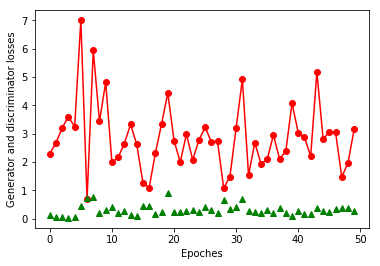

In [16]:
plt.plot(g_loss_vals,'ro-',d_loss_vals,'g^')
plt.xlabel('Epoches')
plt.ylabel('Generator and discriminator losses')
plt.show()